In [1]:
# Import libraries
import keras
import os
import tensorflow as tf
from keras import backend as k
import numpy as np
import matplotlib.pyplot as plt

2024-01-22 21:01:20.693912: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-22 21:01:20.735656: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set Keras backend for image data format
keras.backend.set_image_data_format('channels_last')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Load data

In [3]:
filename ='../../../data/foresttree/Carlos_Vera_Arteaga.npz' 

In [4]:
data = np.load(filename)


In [5]:
data['X'].shape

(537, 400, 400, 3)

In [6]:
data['Y'].shape

(537,)

In [7]:
def generate_train_image_pairs(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    label_wise_samples = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                       label == curr_label])
    samples = {key: len(value) for key, value in label_wise_indices.items()}
    for i in range(len(label_wise_indices)):
        if i in label_wise_indices.keys(): # Added by Ou, check if the key exists
            label_wise_samples[i] = label_wise_indices[i][0:min(samples.values())] 

    pair_images = []
    pair_labels = []
    pair_index = []
    for index, image in enumerate(images_dataset):
        if index in np.ndarray.flatten(np.array(([*label_wise_samples.values()]))):
            pos_indices = label_wise_samples.get(labels_dataset[index])
            pos_index = np.random.choice(pos_indices)
            pos_image = images_dataset[pos_index]
            pair_images.append((image, pos_image))
            pair_labels.append(1)
            pair_index.append((index,pos_index))

            neg_indices = np.setdiff1d(np.ndarray.flatten(np.array(([*label_wise_samples.values()]))), pos_indices)
            neg_index = np.random.choice(neg_indices)
            neg_image = images_dataset[neg_index]
            pair_images.append((image, neg_image))
            pair_index.append((index,neg_index))
            pair_labels.append(0)
        else:
            continue
    return np.array(pair_images), np.array(pair_labels), np.array(pair_index)

In [8]:
images_pair, labels_pair, index_pair = generate_train_image_pairs(data['X'], data['Y'])
images_pair.shape

(244, 2, 400, 400, 3)

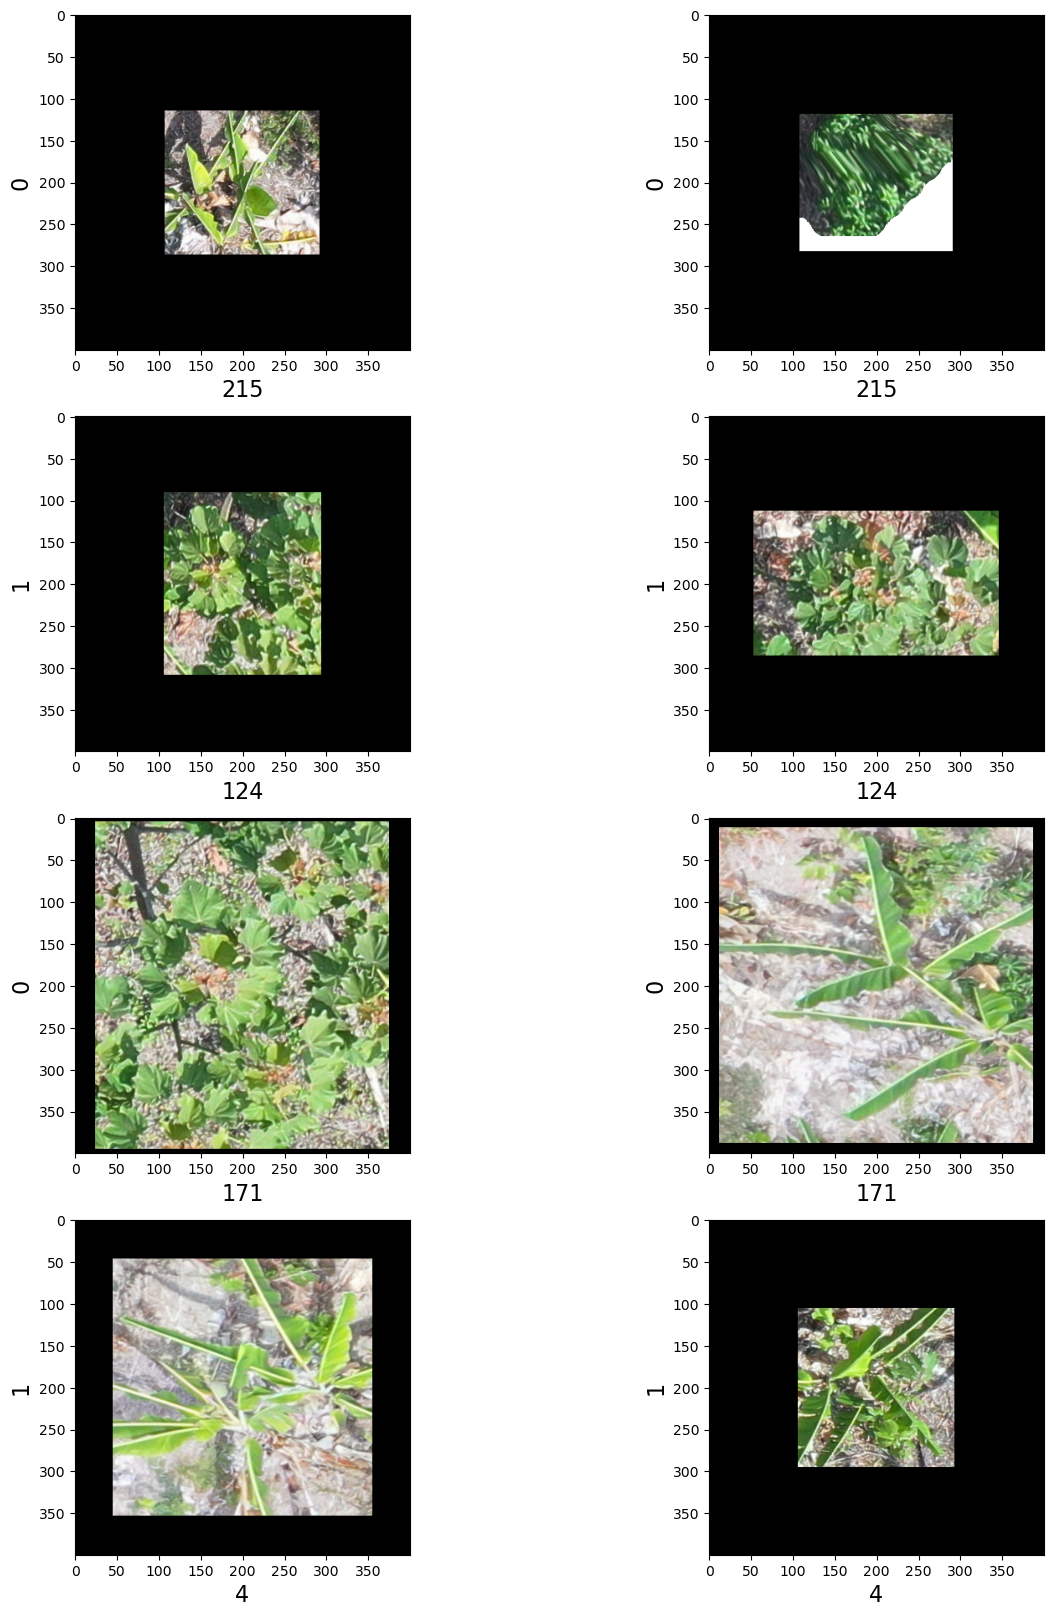

In [9]:
fig = plt.figure(figsize=(15, 20))
j = 0
for i in range(4):
    # idx = np.random.randint(6624)
    sub = fig.add_subplot(4, 2, j + 1)
    j = j+1
    idx = np.random.randint(images_pair.shape[0])
    # sub.imshow(images_pair[idx,0,:,:,:].transpose(1,2,0).astype('int'))
    sub.imshow(images_pair[idx,0,:,:,:].astype('int'))
    sub.set_ylabel(labels_pair[idx], fontsize=16)
    sub.set_xlabel(idx, fontsize=16)
    sub = fig.add_subplot(4, 2, j + 1)
    j = j+1
    # sub.imshow(images_pair[idx,1,:,:,:].transpose(1,2,0).astype('int'))
    sub.imshow(images_pair[idx,1,:,:,:].astype('int'))
    sub.set_ylabel(labels_pair[idx], fontsize=16)
    sub.set_xlabel(idx, fontsize=16)

plt.show(block=True)

## Model setup

In [10]:
def _create_model(nneurons, nfilters, ndropout, npool):
    inputs = keras.Input((400, 400, 3))
    x = keras.layers.Conv2D(nneurons[0], (nfilters[0], nfilters[0]), padding="same", activation="relu")(inputs)
    x = keras.layers.MaxPooling2D(pool_size=(npool[0], npool[0]), data_format='channels_last')(x)
    x = keras.layers.Dropout(ndropout[0])(x)

    x = keras.layers.Conv2D(nneurons[1], (nfilters[1], nfilters[1]), padding="same", activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(npool[1], npool[1]), data_format='channels_last')(x)
    x = keras.layers.Dropout(ndropout[1])(x)

    x = keras.layers.Conv2D(nneurons[2], (nfilters[2], nfilters[2]), padding="same", activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(npool[2], npool[2]), data_format='channels_last')(x)
    x = keras.layers.Dropout(ndropout[2])(x)

    pooledOutput = keras.layers.GlobalAveragePooling2D()(x)
    pooledOutput = keras.layers.Dense(nneurons[3])(pooledOutput)
    outputs = keras.layers.Dense(nneurons[4])(pooledOutput)

    model = keras.Model(inputs, outputs)
    return model

def _euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))

def siamese_model(nneurons, nfilters, ndropout, npool):
    feature_extractor_model = _create_model(nneurons, nfilters, ndropout, npool)
    imgA = keras.Input(shape=(400, 400, 3))
    imgB = keras.Input(shape=(400, 400, 3))
    featA = feature_extractor_model(imgA)
    featB = feature_extractor_model(imgB)
    distance = keras.layers.Lambda(_euclidean_distance)([featA, featB])
    outputs = keras.layers.Dense(1, activation="sigmoid")(distance)
    model = keras.Model(inputs=[imgA, imgB], outputs=outputs)
    return model

In [11]:
nneurons = [96, 256, 384, 1024, 128]
nfilters = [11, 5, 3]
ndropout = [0.3, 0.3, 0.3]
npool = [2, 2, 2]

model = siamese_model(nneurons, nfilters, ndropout, npool)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  2060160   ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['model[0][0]',         

In [12]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

## Model training

In [14]:
images_pair[:10, 0]

(244, 400, 400, 3)

In [15]:
history = model.fit([images_pair[:10, 0], images_pair[:10, 1]], labels_pair[:], validation_split=0.2, batch_size=16, epochs=20)

Epoch 1/20
1/1 [==============================] - 42s 42s/step - loss: 43.9752 - accuracy: 0.5000 - val_loss: 10.4841 - val_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 41s 41s/step - loss: 64.4029 - accuracy: 0.5000 - val_loss: 1.7360 - val_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 41s 41s/step - loss: 11.2767 - accuracy: 0.5000 - val_loss: 0.8824 - val_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 42s 42s/step - loss: 2.3273 - accuracy: 0.5000 - val_loss: 0.6541 - val_accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 43s 43s/step - loss: 1.3131 - accuracy: 0.5000 - val_loss: 0.6906 - val_accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 44s 44s/step - loss: 0.6898 - accuracy: 0.5000 - val_loss: 0.6844 - val_accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 43s 43s/step - loss: 0.6992 - accuracy: 0.5000 - val_loss: 0.6866 - val_accuracy: 0.5000
Epoch 8/20
1/1 [=======